In [1]:
import pandas as pd


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler

from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, roc_auc_score, precision_recall_curve, auc,f1_score


from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report


# Load your dataset
df = pd.read_csv("fraud_reduced.csv", index_col=0)


In [2]:
X = df.drop("Class", axis=1)
y = df["Class"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, random_state=42, test_size=0.33, stratify=y)

undersample = RandomUnderSampler(sampling_strategy=0.3, random_state=42)  

# Apply the pipeline to balance the training set
X_train_resampled, y_train_resampled = undersample.fit_resample(X_train, y_train)

In [3]:
len(X_train_resampled)

1430

In [4]:

param_grid = {
    'C': [ 1, 3, 5, 7, 10, 15, 20],
    'kernel': ['poly'],
    'degree': [1, 2, 3, 4, 5],
    'probability' : [True]
}

# Create the SVM classifier
rnd_clf = SVC(random_state=42)

scoring = {
    'roc_auc': make_scorer(roc_auc_score, needs_threshold=True),
    'f1_score' : make_scorer(f1_score)
}

# Create a GridSearchCV instance with cross-validation
grid_search = GridSearchCV(
    rnd_clf,
    param_grid=param_grid,  
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=None),  # Cross-validation strategy
    n_jobs=-1,  # Use all available CPU cores
    scoring=scoring,
    refit='f1_score',
    verbose=2,
)

# Fit the grid search to the training data
grid_search.fit(X_train_resampled, y_train_resampled)


Fitting 5 folds for each of 35 candidates, totalling 175 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             estimator=SVC(random_state=42), n_jobs=-1,
             param_grid={'C': [1, 3, 5, 7, 10, 15, 20],
                         'degree': [1, 2, 3, 4, 5], 'kernel': ['poly'],
                         'probability': [True]},
             refit='f1_score',
             scoring={'f1_score': make_scorer(f1_score),
                      'roc_auc': make_scorer(roc_auc_score, needs_threshold=True)},
             verbose=2)

In [5]:
grid_search.best_params_

{'C': 10, 'degree': 3, 'kernel': 'poly', 'probability': True}

In [6]:
grid_search.best_estimator_

SVC(C=10, kernel='poly', probability=True, random_state=42)

In [7]:
grid_search.best_estimator_.get_params()

{'C': 10,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'poly',
 'max_iter': -1,
 'probability': True,
 'random_state': 42,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [8]:
clf_svm = grid_search.best_estimator_

In [9]:
y_pred = clf_svm.predict(X_test)

[[93704   121]
 [   27   135]]


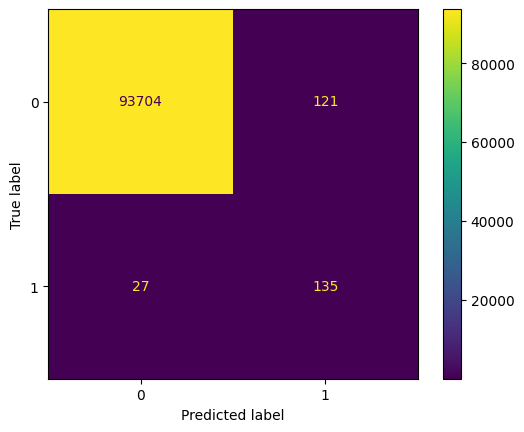

In [10]:
cm = confusion_matrix(y_test, y_pred)
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf_svm.classes_)
disp.plot()

In [280]:
class_report = classification_report(y_test, y_pred)
print("Classification Report:")
print(class_report)

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     93825
           1       0.47      0.83      0.60       162

    accuracy                           1.00     93987
   macro avg       0.74      0.92      0.80     93987
weighted avg       1.00      1.00      1.00     93987



In [11]:
import joblib

joblib.dump(value= clf_svm, filename='SVMModel.pkl')

['SVMModel.pkl']